# mode resolution
check resolution of vertical mode, based on horizontal wavenumber from dispersion relation vs horizontal grid size, and number of points between nodes

In [45]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.rcParams['font.family'] = "serif"

import numpy as np
from netCDF4 import Dataset#, MFDataset
from scipy.ndimage import gaussian_filter

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = KRYPTON+"local_ruchba/"

In [3]:
simul = "luckym2"
data_mod = KRYPTON+'{0}_modemap/{0}_modemap_20.nc'.format(simul)
grid_file = KRYPTON+"/lucky_corgrd.nc"

omega = 2*np.pi/(12.42*3600) # M2 freq, rad/s

nc =  Dataset(data_mod, "r")
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
lam = 2*np.pi*nc.variables["mode_speed"][:]
nc.close()

ncgrd = Dataset(grid_file,'r')
topo = ncgrd.variables['h'][eta,:][:,xi]
fcor = ncgrd.variables['f'][eta,:][:,xi]
res = np.sqrt( (1./ncgrd.variables['pn'][:])**2 + (1./ncgrd.variables['pm'][:])**2 ).mean()
ncgrd.close()
print("shape :",topo.shape)

lam /= np.sqrt(omega**2-fcor**2)*1e3 # horizontal wavelength in km

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


shape : (500, 500)


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


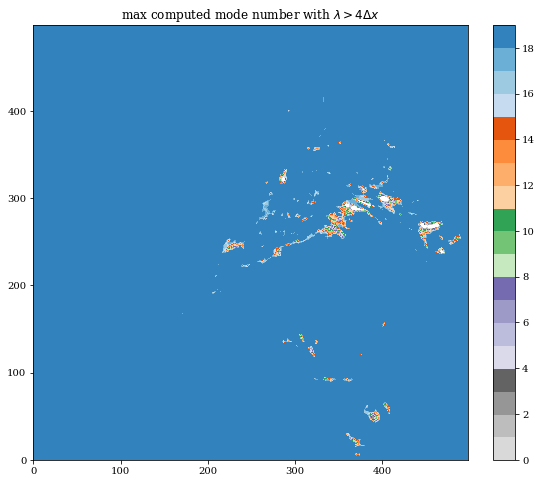

In [4]:
# horizontal resolution

data = np.nanargmax(np.r_[lam, np.zeros(lam.shape[1:])[None,:,:]]<4e-3*res, axis=0)-1
data = np.ma.masked_where(np.isnan(lam[0,:,:]), data)

fig = plt.figure(figsize=(9,8))
plt.contourf(data, levels = np.arange(20), cmap="tab20c_r")
plt.colorbar(fraction=.05)
plt.gca().set_aspect('equal')

plt.title(r'max computed mode number with $\lambda>4 \Delta x$')

if False:
    fig.savefig('pictures/{}_max_resolved_mode.png'.format(simul), magnification="auto", bbox_inches="tight", dpi=200)

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


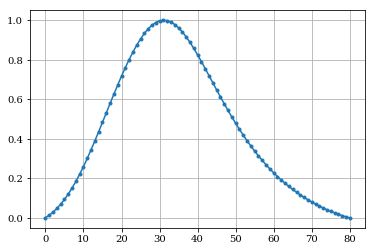

In [65]:
nc = Dataset(data_mod, "r")
wmod = nc.variables['w_modes'][1,:,:,:]
nc.close()

def calc_nzeros(tab1d):
    # compute number of grid points between consecutive zeros
    return np.diff(np.nonzero(np.diff(np.sign(tab1d)))).min()

nzos = np.apply_along_axis(calc_nzeros, 0, wmod.reshape(Nz,-1)).reshape(wmod.shape[1:]) # not very efficient but that will do

plt.plot(wmod[:,0,0], ".-")
plt.grid()

In [66]:
### compute number of grid points between zeros of each modes

nmod = 20
nzeros = np.zeros((nmod-1,)+wmod.shape[1:])
for imod in range(1,nmod):
    print(imod, end=", ")
    nc = Dataset(data_mod, "r")
    wmod = nc.variables['w_modes'][imod,:,:,:]
    nc.close()
    nzeros[imod-1,:,:] = np.apply_along_axis(calc_nzeros, 0, wmod.reshape(Nz,-1)).reshape(wmod.shape[1:]) 
    

1, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

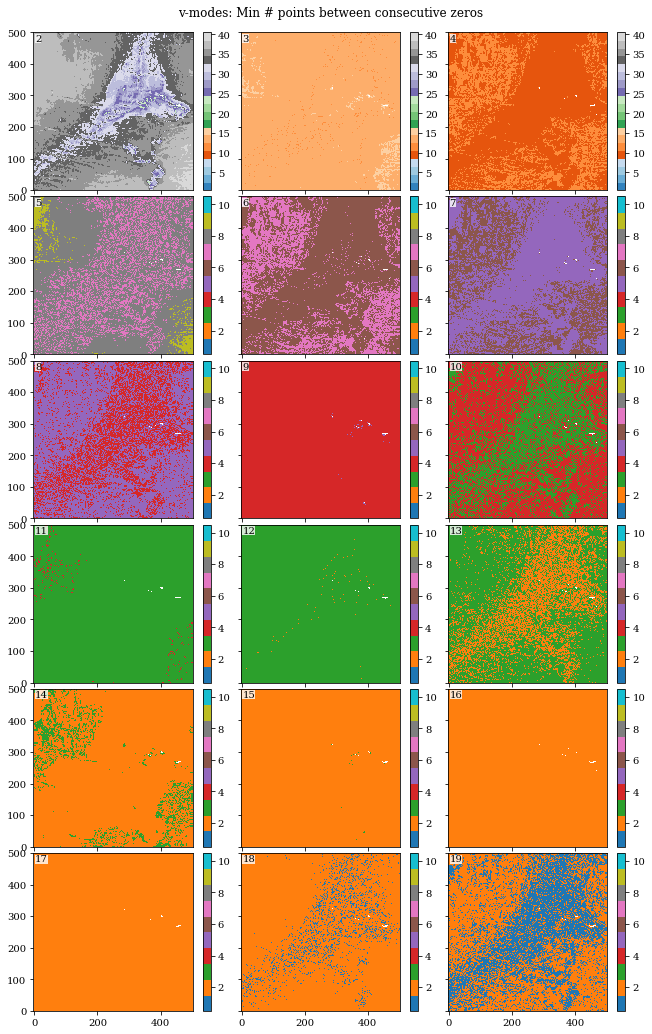

In [98]:
### plot result

fig, axs = plt.subplots(6, 3, sharex=True, sharey=True, figsize=(11,18))
axs = axs.ravel()

for imod in range(1,nmod-1):
    ax = axs[imod-1]
    nzos = np.ma.masked_where(topo<300, nzeros[imod,:,:])
    if nzos.max() > 10:
        minzo, maxzo = 1, 40
        cmap = "tab20c"
#    elif nzos.max()>10:
#        minzo, maxzo = 1, 20
#        cmap = "tab20"
    else:
        minzo, maxzo = 1, 10
        cmap = "tab10"
        #cmap = mpl.colors.ListedColormap(["C{}".format(ii) for ii in range(10)], name='from_list', N=None)
    hpc = ax.pcolormesh(nzos, cmap=cmap, vmin=minzo-.5, vmax=maxzo+.5)
    ax.set_aspect("equal")
    ax.text(.01, .99, str(imod+1), transform=ax.transAxes, va="top", ha="left", \
            bbox=dict(facecolor='white', alpha=.8, pad=.01, edgecolor="none"))
    fig.colorbar(hpc, ax=ax)
    
fig.subplots_adjust(wspace=.04, hspace=.04)
fig.suptitle('v-modes: Min # points between consecutive zeros', y=.9)

if True:
    fig.savefig('pictures/{}_z-mode_resolution.png'.format(simul), magnification="auto", bbox_inches="tight", dpi=200)

In [142]:
### compter les zeros -- discard first and last points

nmod = 20
cntzos = np.zeros((nmod-1,)+wmod.shape[1:])
for imod in range(1,nmod):
    print(imod, end=", ")
    nc = Dataset(data_mod, "r")
    wmod = nc.variables['w_modes'][imod,:,:,:]
    nc.close()
    
    cntzos[imod-1,:,:] = (abs(np.diff(np.sign(wmod[1:-2,:,:]), axis=0))>0).sum(axis=0)

1, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

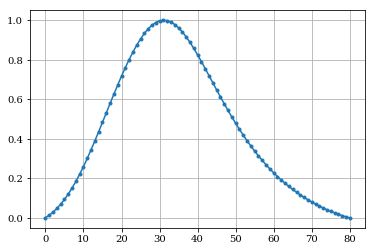

In [141]:
imod = 1
nc = Dataset(data_mod, "r")
wmod = nc.variables['w_modes'][imod,:,:,:]
nc.close()

plt.plot(wmod[:,0,0], ".-")
plt.grid(True)

np.sign(wmod[1:-2,0,0])

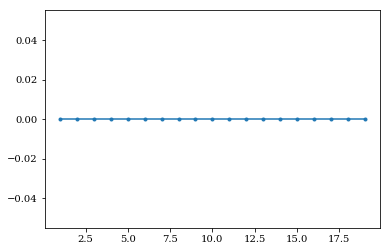

In [161]:
failers = np.zeros(nmod-1)
for imod in range(nmod-1):
    failers[imod] = (np.ma.masked_where(topo<300, cntzos[imod,:,:])!=imod).sum()
plt.plot(np.arange(1, nmod), failers, ".-")

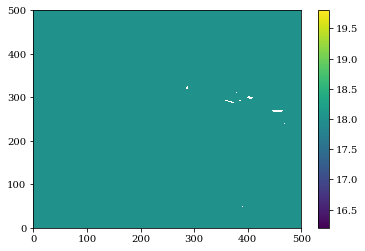

In [163]:
plt.pcolormesh(np.ma.masked_where(topo<300, cntzos[-1,:,:]))
plt.colorbar()

In [160]:
(np.ma.masked_where(topo<300, cntzos[18,:,:])!=18).sum()


0

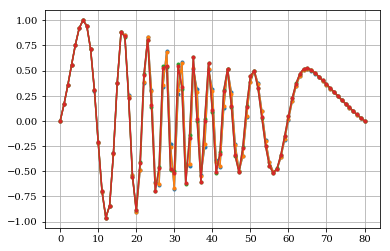

In [7]:
Nz = wmod.shape[0]
data = wmod[:,:2,:2]
plt.plot(data.reshape((Nz,-1)), ".-")
plt.grid(True)

#np.argwhere(abs(np.diff(lesign))>0)

In [14]:
lesign = np.sign(data)
np.unravel_index(np.argwhere(abs(np.diff(lesign, axis=0))>0), data.shape)

(array([[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 2,  0,  0],
        [ 2,  0,  0],
        [ 2,  0,  0],
        [ 2,  0,  0],
        [ 3,  0,  0],
        [ 3,  0,  0],
        [ 3,  0,  0],
        [ 3,  0,  0],
        [ 4,  0,  0],
        [ 4,  0,  0],
        [ 4,  0,  0],
        [ 4,  0,  0],
        [ 5,  0,  0],
        [ 5,  0,  0],
        [ 5,  0,  0],
        [ 5,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        [ 6,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 8,  0,  0],
        [ 8,  0,  0],
        [ 8,  0,  0],
        [ 8,  0,  0],
        [ 8,  0,  0],
        [ 8,  0,  0],
        [ 8,  0,  0],
        [ 8,  0,  0],
        [ 8,  0,  0],
        [ 

In [19]:
val, x, y = np.nonzero(np.diff(lesign, axis=0))

In [20]:
val[(x==0) & (y==0)]

array([ 0,  9, 14, 18, 21, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 45, 48,
       53, 59, 79])